# LSTM Multi-Feature Stock Price Prediction with Keras

# Overview

This is a LSTM daily stock price and tradint volume forecast project using four features (AAPL and SPY's closing price and volume), and 10 time steps of inputs and last time step of output. 


# Background for LSTM
The long short-term memory (LSTM) unit is an improved version of gated recurrent unit (GRU), which tries to resolve the [vanishing gradient problem](http://neuralnetworksanddeeplearning.com/chap5.html) and keep the long term "memory" activated.

See my other [project](https://github.com/ginochen/LSTM/blob/master/LSTM_min_temp.ipynb) for a picture summary on the network architecture.

# Data 
Daily data of [AAPL](https://finance.yahoo.com/quote/AAPL/history?p=AAPL) and [SPY](https://finance.yahoo.com/quote/SPY/history?p=SPY&.tsrc=fin-srch) downloaded from Yahoo Finance.

Then create batches of data with a generator:

In [719]:
class KerasBatchGenerator(object):

#    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
    def __init__(self, data, num_steps, batch_size, ndim, skip_step=5):
        self.data = data
        self.num_steps = num_steps # forecast time steps
        self.batch_size = batch_size 
        self.ndim = ndim # number of feature dimensions
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps, self.ndim))
        y = np.zeros((self.batch_size, self.ndim))# make sure to set the last dim to one element, otherwise Keras won't `fit` the model!!!!!!!!!!!!!!!
#        y = np.zeros((self.batch_size, self.num_steps))# if timedistributed not used
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                # More-to-one (multiple inputs to one output in the end)    
                x[i,:,:], y[i,:] = more_to_one(self)
                # More-to-more (multiple inputs to multiple outputs)
                #x[i,:,:], y[i,:,:] = more_to_more(self)
                self.current_idx += self.skip_step                
            yield x, y
    def more_to_more(self):
        x = self.data[self.current_idx    :self.current_idx + self.num_steps,    :] # (batchsize,nstep,ndim)
        y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1,:]
        return x,y
    def more_to_one(self):   
        x = self.data[self.current_idx    :self.current_idx + self.num_steps,    :]
        y = self.data[self.current_idx + self.num_steps + 1,:]
        return x,y

In [720]:
def inverse_transform(x_std, xmin, xmax):
    return x_std*(xmax-xmin) + xmin

Import and create the batched data: 

In [721]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
datapath = 'data/'
series_aapl = pd.read_csv('data/AAPL.csv')
series_spy = pd.read_csv('data/SPY.csv')
#series = pd.concat([series_aapl['Close'],series_aapl['Volume'],series_spy['Close'],series_spy['Volume']],axis=1)
series = np.stack((series_aapl['Close'].values,series_aapl['Volume'].values,series_spy['Close'].values,series_spy['Volume'].values),axis=1)
n = series.shape[0] # total time series length
nsteps = 10
batchsize = 20 # Number of samples per gradient update.
lagt=1
ndim = series.shape[1] # number of features
# split data into 80% training, 10% validating,10% testing
train,valid,test = series[:round(0.8*n),:], series[round(0.8*n):round(0.9*n),:], series[round(0.9*n):,:]
print('Data snippet: \n',train[:5,:],test[:5,:],test[:10,:])
# scale the data into range of 0 to 1
scaler = MinMaxScaler()
#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#X_scaled = X_std * (max - min) + min = X_std * 1 + 0 = X_std when scaled between (0,1)
# X = X_std*(X.max - X.min) + X.min
scaler.fit(test)
xmin, xmax = scaler.data_min_, scaler.data_max_
#scaler.fit(valid)
#valid_min, valid_max = scaler.data_min_, scaler.data_max_
#scaler.fit(test)
#test_min, test_max = scaler.data_min_, scaler.data_max_


train = scaler.fit_transform(X=train)
valid = scaler.fit_transform(X=valid)
test  = scaler.fit_transform(X=test)
print('Transformed data snippet: \n AAPL closing price, AAPL trading volume, SPY closing price, SPY trading volume \n', train[:5])

# create batched data
train_data_generator = KerasBatchGenerator(train, nsteps, batchsize, ndim, skip_step=nsteps)
valid_data_generator = KerasBatchGenerator(valid, nsteps, batchsize, ndim, skip_step=nsteps)

#x_train,x_valid        = series[:round(0.8*n)], series[round(0.8*n):round(0.9*n)]
#y_train,y_valid,y_test = series.iloc[:,0][lagt:round(0.8*n)+lagt], series.iloc[:,0][round(0.8*n)+lagt:round(0.9*n)+lagt], series.iloc[:,0][round(0.9*n)+lagt:]
print('\n Shape of training and validation data set:\n',train.shape,valid.shape)




#series_goog = pd.read_csv('data/GOOG.csv')
#series_fund = pd.read_csv('nyse/fundamentals.csv')
#print(series_fund.columns)
#print(series_fund[series_fund['Ticker Symbol']=='AAP'])
#print(series_fund[series_fund['Ticker Symbol']=='AAP'].count)
#series_price = pd.read_csv('nyse/prices-split-adjusted.csv', error_bad_lines=False)
#series_price = pd.read_csv('nyse/prices.csv')
#print(series_price[series_price['symbol']=='AAP'])
#series.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990':'mint'},inplace=True) # rename minimum temp to 'mint'
#y = pd.to_numeric(series["mint"],downcast='float')
#y.index = pd.DatetimeIndex(start='1981-01-01',end='1990-12-31',freq='d')
#freq=365 # sampling freq
#train, valid = series_price[:freq*9], series_price[freq*9:]
#train.index, valid.index = y.index[:freq*9], y.index[freq*9:]
#print(series_price.head(35), series_fund[]
#series_fund.iloc[series_fund['Ticker Symbol']=='AAPL',:]
#series_fund.iloc[series_fund['Ticker Symbol']=='AAPL']



Data snippet: 
 [[4.55171430e+01 7.04396000e+07 1.22489998e+02 1.56107100e+08]
 [4.51542850e+01 9.58860000e+07 1.21610001e+02 1.86621600e+08]
 [4.54328580e+01 9.60568000e+07 1.22099998e+02 2.21387400e+08]
 [4.52357140e+01 9.03210000e+07 1.21639999e+02 1.58017600e+08]
 [4.40042840e+01 1.98961700e+08 1.20199997e+02 2.39068800e+08]] [[1.74220001e+02 5.11051000e+07 2.83179993e+02 1.34816100e+08]
 [1.71110001e+02 4.15290000e+07 2.83299988e+02 8.45873000e+07]
 [1.71509995e+02 3.91430000e+07 2.86579987e+02 1.07743100e+08]
 [1.67960007e+02 5.06404000e+07 2.84679993e+02 9.01183000e+07]
 [1.66970001e+02 4.60482000e+07 2.81760010e+02 1.31796400e+08]] [[1.74220001e+02 5.11051000e+07 2.83179993e+02 1.34816100e+08]
 [1.71110001e+02 4.15290000e+07 2.83299988e+02 8.45873000e+07]
 [1.71509995e+02 3.91430000e+07 2.86579987e+02 1.07743100e+08]
 [1.67960007e+02 5.06404000e+07 2.84679993e+02 9.01183000e+07]
 [1.66970001e+02 4.60482000e+07 2.81760010e+02 1.31796400e+08]
 [1.67429993e+02 3.24789000e+07 2.818

# Build and train the model

In [722]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed,Activation
import numpy as np
hdim = 128
nepochs = 100
model = Sequential()
#model.add(LSTM(hdim, batch_input_shape=(batchsize,nsteps,ndim),  return_sequences=True)) #input_shape required only at the first layer
model.add(LSTM(hdim, input_shape=(nsteps,ndim), return_sequences=True)) #input_shape required only at the first layer
#model.add(LSTM(hdim, return_sequences=True)) 
# units: hidden nodes
# Input: (batch_size, timesteps, input_dim) # input_shape takes only (timesteps, input_dim) without batch_size
# Output: (batch_size, timesteps, units) if return_sequences=True, else, 2D tensor with shape `(batch_size, units)`
# set return_sequences to True to return the 
# full history of hidden state outputs at all times (i.e. the shape of output is (n_samples, n_timestamps, n_outdims)), 
# or the return value contains only the output at the last timestamp (i.e. the shape will be (n_samples, n_outdims)), 
# which is invalid as the input of the next LSTM layer. 
#
# lstm1, state_h, state_c = LSTM(128, return_sequences=True, return_state=True) 
# with return_state set to true, this returns the sequential hidden states, final hidden state and final cell states. 
model.add(Dropout(0.2))
model.add(LSTM(hdim,return_sequences=False)) # no need to specify input_shape anymore
#model.add(LSTM(hdim,return_sequences=False)) # no need to specify input_shape anymore
model.add(Dropout(0.2))
#model.add(TimeDistributed(Dense(1))) # y(batchsize,nsteps)
model.add(Dense(4, activation='linear')) # essentially applies 'linear' activation, a(x)=x, which returns the Dense output directly
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# metrics: shows how the accuracy is improving during training
checkpointer = keras.callbacks.ModelCheckpoint(filepath=datapath + '/model-{epoch:02d}.hdf5', verbose=1)
# include the epoch in its naming of the model, which is good for keeping track of things.
model.summary()
model.fit_generator(train_data_generator.generate(), len(train)//(batchsize*nsteps), epochs=nepochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(valid)//(batchsize*nsteps), callbacks=[checkpointer])
# validation_data: evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_208 (LSTM)              (None, 10, 128)           68096     
_________________________________________________________________
dropout_195 (Dropout)        (None, 10, 128)           0         
_________________________________________________________________
lstm_209 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_196 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 4)                 516       
Total params: 200,196
Trainable params: 200,196
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 41s 5s/step - loss: 0.0811 - acc: 0.4438 - val_loss: 0.0509 - val_acc: 0.2000

Epoch 

Epoch 41/100
8/8 [==============================] - 0s 41ms/step - loss: 0.0045 - acc: 0.8438 - val_loss: 0.0138 - val_acc: 0.6500

Epoch 00041: saving model to data//model-41.hdf5
Epoch 42/100
8/8 [==============================] - 0s 34ms/step - loss: 0.0041 - acc: 0.7875 - val_loss: 0.0141 - val_acc: 0.6500

Epoch 00042: saving model to data//model-42.hdf5
Epoch 43/100
8/8 [==============================] - 0s 34ms/step - loss: 0.0039 - acc: 0.7875 - val_loss: 0.0133 - val_acc: 0.6500

Epoch 00043: saving model to data//model-43.hdf5
Epoch 44/100
8/8 [==============================] - 0s 44ms/step - loss: 0.0042 - acc: 0.8125 - val_loss: 0.0139 - val_acc: 0.6500

Epoch 00044: saving model to data//model-44.hdf5
Epoch 45/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0047 - acc: 0.7188 - val_loss: 0.0129 - val_acc: 0.6500

Epoch 00045: saving model to data//model-45.hdf5
Epoch 46/100
8/8 [==============================] - 0s 43ms/step - loss: 0.0043 - acc: 0.8313 -

8/8 [==============================] - 0s 55ms/step - loss: 0.0044 - acc: 0.7500 - val_loss: 0.0134 - val_acc: 0.6500

Epoch 00086: saving model to data//model-86.hdf5
Epoch 87/100
8/8 [==============================] - 0s 39ms/step - loss: 0.0040 - acc: 0.7938 - val_loss: 0.0152 - val_acc: 0.6500

Epoch 00087: saving model to data//model-87.hdf5
Epoch 88/100
8/8 [==============================] - 0s 39ms/step - loss: 0.0042 - acc: 0.7875 - val_loss: 0.0127 - val_acc: 0.6500

Epoch 00088: saving model to data//model-88.hdf5
Epoch 89/100
8/8 [==============================] - 0s 53ms/step - loss: 0.0270 - acc: 0.6625 - val_loss: 0.0210 - val_acc: 0.6500

Epoch 00089: saving model to data//model-89.hdf5
Epoch 90/100
8/8 [==============================] - 0s 49ms/step - loss: 0.0116 - acc: 0.8000 - val_loss: 0.0138 - val_acc: 0.6500

Epoch 00090: saving model to data//model-90.hdf5
Epoch 91/100
8/8 [==============================] - 0s 47ms/step - loss: 0.0053 - acc: 0.8250 - val_loss: 0.

In [765]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    print('[Model] Predicting Sequences Multiple...')
    prediction_seqs = []
    #curr_frame=np.zeros((1,prediction_len, data.shape[1]))
    #print(curr_frame.shape)
    for i in range(int(len(data)/prediction_len)): # loop between multiple frames
        #curr_frame[0,0,:] = data[i*prediction_len,:]
        curr_frame = data[i*prediction_len:(i+1)*prediction_len,:]
        predicted = []
        for j in range(prediction_len): # loop within a frame 
            #predicted.append(model.predict(curr_frame)) # newaxis just adds a dimension
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])) # newaxis just adds a 1-sample-batch dimension
            # model.predict returns a shape (1,10,1), which is essentially 10 steps forward
            #curr_frame = curr_frame[0,1:,:]
            #print(curr_frame,predicted[-1])
            #print(curr_frame[1:,:])
            #print(predicted[-1])
            #curr_frame = curr_frame[1:,:]
            # march forward one step by a time!!!!!!!!!!!!!!!!!!!!!!!!!!! do this tomorrow!
            # so start out at the 
            #curr_frame = np.concatenate((curr_frame[1:,:],predicted[-1]),axis=0)
            curr_frame = np.insert(curr_frame[1:,:], [window_size-2], predicted[-1], axis=0) # insert predicted at the last row index 
#            curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0) # insert predicted at the last row index 
            #print(curr_frame)
            prediction_seqs.append(predicted[-1])
#            print(prediction_seqs)
    return prediction_seqs

# Prediction

In [820]:

#from keras.models import load_model
# load model from single file
#model = load_model('data/model-99.hdf5')
# make predictions
#yhat = model.predict(np.reshape(test[0:10,:],(10,4,1)), batch_size=1, steps=10, verbose=2)
#x = np.zeros((20,10,4))
#print(test[0:10,:])
#x[0,:,:] = test[0:10,:]

#print(yhat)
#print(*yhat)
#yhat = model.predict(x)

#yhat = predict_sequences_multiple(model, test, 1, nsteps)
print(yhat[0])
yhat = np.asarray(yhat).reshape(20,10,4)
print(yhat.shape)
ypred = np.zeros((batchsize,nsteps,ndim))
xin = np.zeros((batchsize,nsteps,ndim))
print(test.shape)
# Un-scaled the data  
for i in range(batchsize):
    ypred[i,:,:] = scaler.inverse_transform(yhat[i,:,:])
    xin[i,:,:]   = scaler.inverse_transform(test[i*nsteps:(i+1)*nsteps,:])
print(ypred[0,:,:],xin[1,:,:])


#print(yhat.shape)
#ypred = inverse_transform(yhat,xmin[0],xmax[0])
#xin = inverse_transform(test[:10,0],xmin[0],xmax[0])
#predictions_multiseq = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
#predictions_fullseq = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
#predictions_pointbypoint = model.predict_point_by_point(x_test)        
# 0.07139935, 0.049592964, 0.0380697, 0.03280621, 0.03569081, 0.03897872, 0.04515948, 0.056872185, 0.07206992, 0.07580703, 0.18185657, 0.19701773, 0.20028599, 0.20325541, 0.20909837, 0.21418989, 0.21997404, 0.22747086, 0.23343688, 0.24240758, 0.2947851, 0.29550692, 0.29823777, 0.30289993, 0.30677494, 0.30912313, 0.31044993, 0.31283846, 0.31825763, 0.32531407, 0.31220546, 0.30361176, 0.29751998, 0.2948487, 0.29412735, 0.29495108, 0.2976027, 0.30282834, 0.30717468, 0.3131449, 0.19974835, 0.2127253, 0.222201, 0.2322881, 0.24206087, 0.2503564, 0.26009, 0.26201558, 0.26633194, 0.27029198, 0.31423548, 0.31483203, 0.3154347, 0.31595895, 0.31589994, 0.31742716, 0.3180437, 0.3203735, 0.32421097, 0.32878298, 0.14821112, 0.15791254, 0.16600038, 0.17091408, 0.17591745, 0.18457815, 0.19676436, 0.20589875, 0.21512434, 0.21987674, 0.4708994, 0.4684323, 0.46481422, 0.45916015, 0.45516962, 0.45244843, 0.45255753, 0.45351648, 0.45380047, 0.45506138, 0.47347322, 0.46730852, 0.46351123, 0.46120742, 0.46046013, 0.4605206, 0.46087185, 0.45823038, 0.45992687, 0.46097612, 0.52079713, 0.5059963, 0.49044228, 0.47767133, 0.46750945, 0.46195945, 0.45871407, 0.45638102, 0.45621136, 0.4577175, 0.41676673, 0.41131058, 0.40888393, 0.40847299, 0.40928945, 0.41296893, 0.41378492, 0.41617596, 0.41619805, 0.4170882, 0.52107847, 0.51007503, 0.49997547, 0.491178, 0.48411068, 0.48036155, 0.4794007, 0.47991192, 0.48236603, 0.4862616, 0.54737365, 0.5309262, 0.51677537, 0.5037164, 0.49327496, 0.48706964, 0.4835153, 0.48261076, 0.48516232, 0.4898596, 0.6937373, 0.68289673, 0.6675644, 0.6506529, 0.63477504, 0.6223792, 0.61507994, 0.6102673, 0.6070703, 0.60376585, 0.81901765, 0.79762113, 0.7724871, 0.74982876, 0.72938997, 0.71427006, 0.70168084, 0.6918716, 0.683864, 0.67837083, 0.87870663, 0.8481289, 0.81807697, 0.7919412, 0.767892, 0.7461892, 0.7287893, 0.71630055, 0.7068536, 0.7023309, 0.83193856, 0.8014885, 0.76961005, 0.7419547, 0.7212208, 0.7051473, 0.69328976, 0.6838905, 0.68436414, 0.67961216, 0.92301124, 0.8925267, 0.86189765, 0.8331146, 0.80857474, 0.78756493, 0.76875913, 0.75257325, 0.7398669, 0.729419, 0.85329705, 0.8387188, 0.81760114, 0.7956654, 0.77728415, 0.759888, 0.7434422, 0.7275541, 0.70961714, 0.69211084, 0.76668876, 0.7453465, 0.7253588, 0.7033379, 0.6835587, 0.6645118, 0.6452475, 0.6293629, 0.6232491, 0.6201117]

[Model] Predicting Sequences Multiple...
[[0.07139935 0.3843733  0.5414808  0.34208813]]
(20, 10, 4)
(201, 4)
[[1.60642044e+02 4.46985560e+07 2.77022858e+02 1.44906592e+08]
 [1.59139664e+02 4.42741760e+07 2.76018005e+02 1.48217360e+08]
 [1.58358093e+02 4.33622880e+07 2.75286102e+02 1.50459504e+08]
 [1.57928497e+02 4.23078080e+07 2.74603790e+02 1.51042160e+08]
 [1.57947083e+02 4.09906760e+07 2.74152344e+02 1.52063072e+08]
 [1.57824326e+02 3.98791320e+07 2.73838623e+02 1.51660032e+08]
 [1.57751511e+02 3.89963360e+07 2.73555084e+02 1.51559040e+08]
 [1.57937973e+02 3.79123720e+07 2.73386414e+02 1.52549568e+08]
 [1.58261429e+02 3.65090480e+07 2.73432709e+02 1.52371216e+08]
 [1.57679565e+02 3.57579200e+07 2.73713135e+02 1.48736720e+08]] [[1.59539993e+02 5.16086000e+07 2.67670013e+02 1.67376100e+08]
 [1.55149994e+02 5.43905000e+07 2.57630005e+02 2.46449500e+08]
 [1.56410004e+02 7.06726000e+07 2.61500000e+02 2.83565300e+08]
 [1.62710007e+02 6.08195000e+07 2.65339996e+02 1.43736000e+08]
 [1.643

Transform the noramlized data back to unnormalized:

In [ ]:
# The transformation is given by:

#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#X_scaled = X_std * (max - min) + min
print(train)



# Plotting

<function matplotlib.pyplot.show(*args, **kw)>

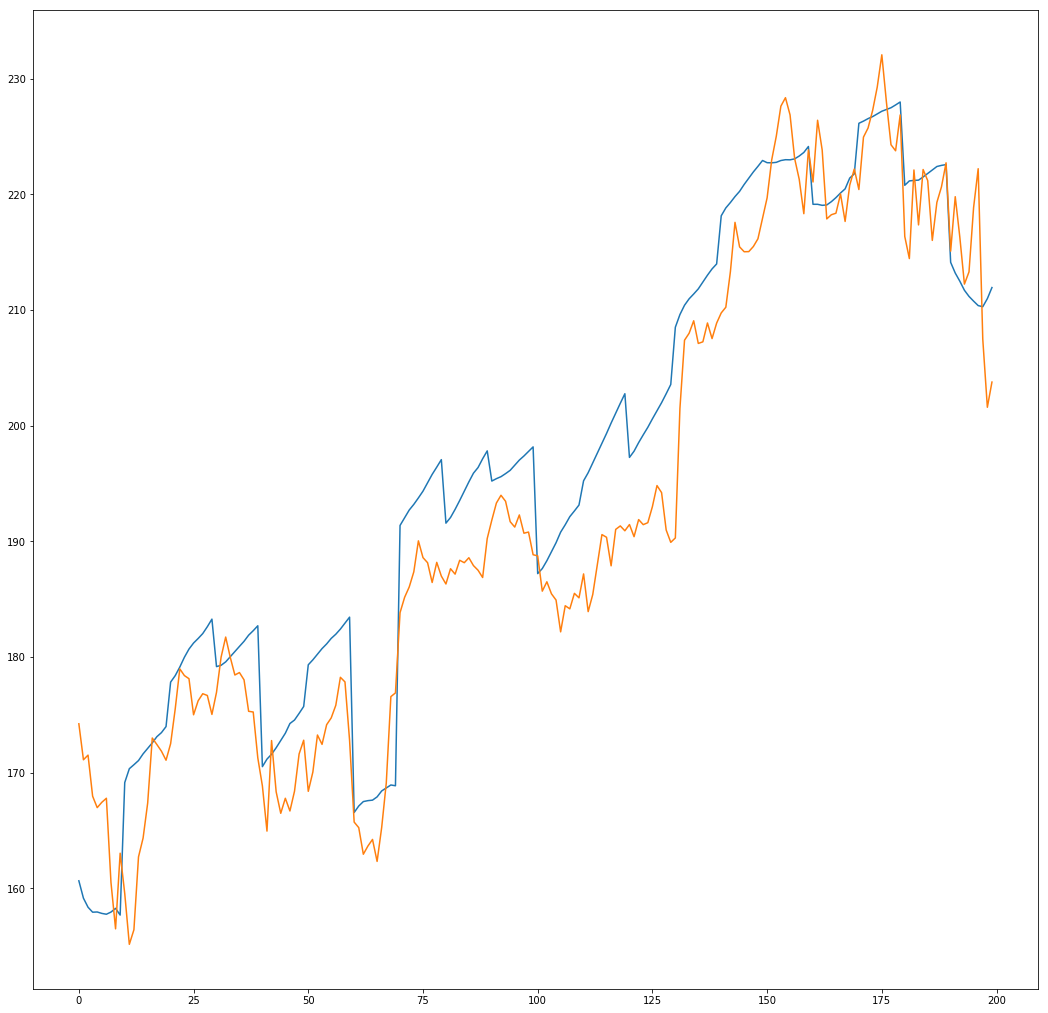

In [846]:
from matplotlib import pyplot as plt
from pandas import DataFrame as df
import time
plt.figure(figsize = (18,18))

#for i in range(3):
plt.plot(ypred[:,:,0].reshape(-1,1))
plt.plot(xin[:,:,0].reshape(-1,1))
plt.show
#plt.hold(True)


In [ ]:
print(yhat)


# Reference
* [LSTM from Keras](https://keras.io/layers/recurrent/#lstm)
* [Keras LSTM tutorial](http://adventuresinmachinelearning.com/keras-lstm-tutorial/)
* [Keras min max scaler](https://github.com/scikit-learn/scikit-learn/blob/bac89c2/sklearn/base.py#L438)
* [sequence prediction by "self-feeding"](https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks)
* [sequence prediction by "self-feeding" (source)](https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction/blob/master/core/model.py)
* [What is TimeDistributed in Keras doing?](https://stackoverflow.com/questions/47305618/what-is-the-role-of-timedistributed-layer-in-keras)

# Random notes
* More-to-More LSTM requires last lstm layer to return_sequences=True and 